# Process control for a press hardening manufacturing line

(1) warming of sheet metal in a furnace unit

(2) handling with a robot system

(3) press hardening

# Approach

What we want:
- process controll after each step within manufacturing line

What we need:
- knowledge about process and nature of variables
- bidirectional relation between input and output variables


## Process structure

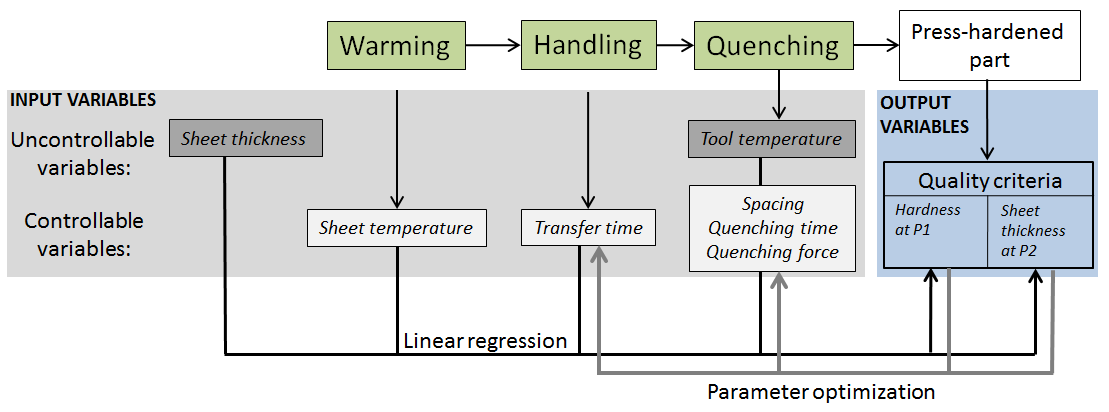

### Process
- 3 processes: Warming / Handling / Quenching

### Variables

- initial conditions: sheet thickness (fix)

- controllable variables: 
    * sheet temperature in "Warming"
    * transfer time in "Handling"
    * spacing / Quenching time / Quenching force in "Quenching"

- uncontrollable variables:
    * tool temperature in "Quenching"
    
- output variables (exemplary):
    * quality criterion - Hardness at P1
    * quality criterion - Sheet thickness at P2
    
## Relation between input and output variables

- linear regression for bidirectional relationship between input and output variables
- solving an inhomogeneous linear system with constraints

# Modeling in R

## libraries

In [15]:
rm(list = ls())

In [16]:
library("stats")
library("limSolve")
library("rapportools")

## Data import in R

In [17]:
files=list.files(pattern="csv")

In [18]:
files

[1] "Autoform_1000csv.csv"       "full_data_autoform_csv.csv"

In [19]:
data_autoform = read.csv(files[1], sep=";")

In [20]:
fix(data_autoform)

In [22]:
#attach(data_autoform)

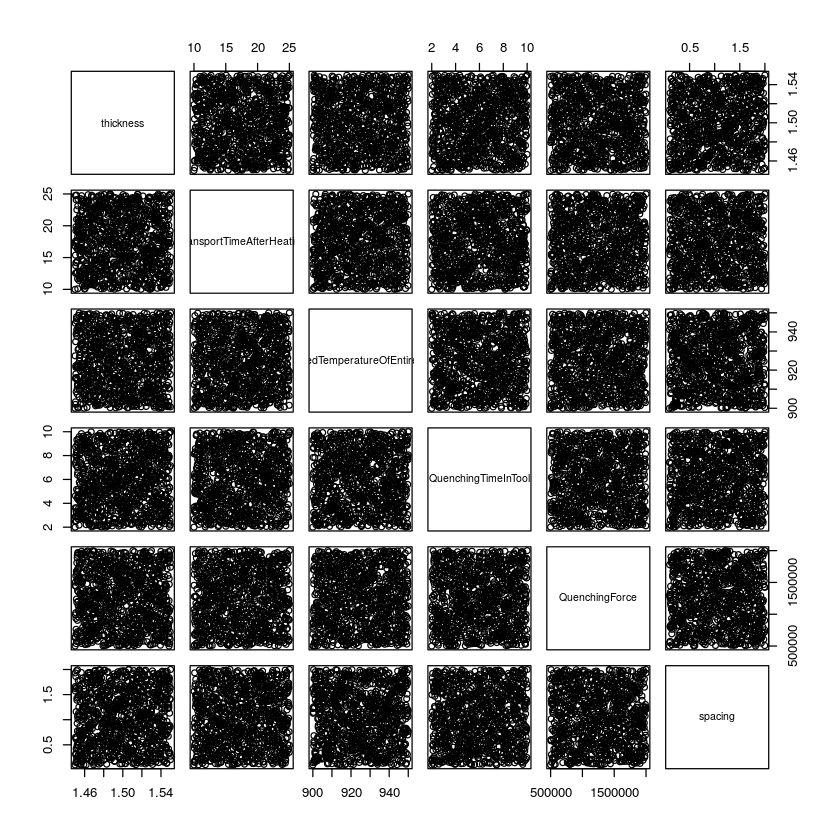

In [23]:
pairs(data_autoform [,2:7]) #, pars = c("theta_1", "theta_2", "theta_3"))


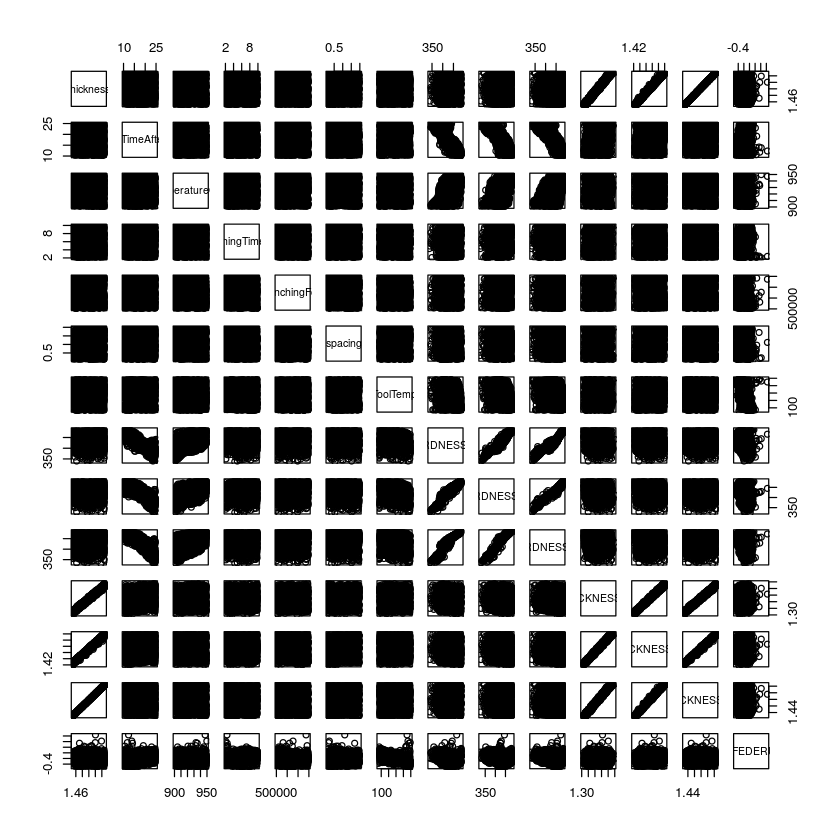

In [24]:
pairs(data_autoform[,2:15])

## Fitting a linear model for quality criterion - "Hardness at P1"

Full linear regression with all variables: 
- sheet thickness (initial)


- sheet temperature (PS1)


- transfer time (PS2)


- tool temperature (PS3)
- spacing (PS3)
- quenching time (PS3)
- quenching force (PS3)

### Null hypothesis - "Hardness at P1"

H_0: there is no relationship between the process parameters and the investigated quality parameter (all coefficients are zero)

### Multiple linear regression - 1st guess - "Hardness at P1"

In [25]:
#train=sample(1:111,80)
summary(data_autoform)

      sim.         thickness     TransportTimeAfterHeating
 Min.   :  1.0   Min.   :1.450   Min.   :10.00            
 1st Qu.:250.5   1st Qu.:1.475   1st Qu.:13.74            
 Median :500.0   Median :1.500   Median :17.49            
 Mean   :500.0   Mean   :1.500   Mean   :17.50            
 3rd Qu.:749.5   3rd Qu.:1.525   3rd Qu.:21.26            
 Max.   :999.0   Max.   :1.550   Max.   :25.00            
                                                          
 EnforcedTemperatureOfEntireSheet QuenchingTimeInTool QuenchingForce   
 Min.   :900.0                    Min.   : 2.000      Min.   : 500000  
 1st Qu.:912.5                    1st Qu.: 3.995      1st Qu.: 874747  
 Median :925.0                    Median : 5.998      Median :1249685  
 Mean   :925.0                    Mean   : 6.000      Mean   :1250008  
 3rd Qu.:937.5                    3rd Qu.: 8.000      3rd Qu.:1624862  
 Max.   :950.0                    Max.   :10.000      Max.   :2000000  
                        

In [26]:
lm_all_P1 = lm(HARDNESS.P1 ~., data=data_autoform[,1:8])#,subset=train)
summary(lm_all_P1)


Call:
lm(formula = HARDNESS.P1 ~ ., data = data_autoform[, 1:8])

Residuals:
    Min      1Q  Median      3Q     Max 
-49.543  -6.861   1.040   6.386  42.178 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -4.720e+02  2.657e+01 -17.761  < 2e-16 ***
sim.                             -5.430e-04  1.112e-03  -0.488   0.6255    
thickness                         1.775e+01  1.110e+01   1.600   0.1100    
TransportTimeAfterHeating        -6.194e+00  7.398e-02 -83.728  < 2e-16 ***
EnforcedTemperatureOfEntireSheet  1.066e+00  2.214e-02  48.162  < 2e-16 ***
QuenchingTimeInTool               3.180e-01  1.386e-01   2.295   0.0220 *  
QuenchingForce                    3.535e-06  7.397e-07   4.779 2.02e-06 ***
spacing                           1.017e+00  5.838e-01   1.742   0.0818 .  
DefaultToolTemperature           -7.349e-02  5.044e-03 -14.570  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 

Based on p-value, we can determine whether or not to reject H_0. p-value small -> reject H_0 -> there is a significant relation between input and output variables

p-values for variables give information about their influence on quality criterion P1_Hardness

-> drop sim / thickness 

### Reduced Model - "Hardness at P1"


In [27]:
lm_reduced_P1 <- update(lm_all_P1, .~. - sim. - thickness)#,subset=train) #- QuenchingTimeInTool
summary(lm_reduced_P1)
P1_Hardness_coeffs=lm_reduced_P1$coefficients


Call:
lm(formula = HARDNESS.P1 ~ TransportTimeAfterHeating + EnforcedTemperatureOfEntireSheet + 
    QuenchingTimeInTool + QuenchingForce + spacing + DefaultToolTemperature, 
    data = data_autoform[, 1:8])

Residuals:
    Min      1Q  Median      3Q     Max 
-49.036  -6.839   1.052   6.496  41.634 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -4.453e+02  2.053e+01 -21.694  < 2e-16 ***
TransportTimeAfterHeating        -6.197e+00  7.399e-02 -83.752  < 2e-16 ***
EnforcedTemperatureOfEntireSheet  1.066e+00  2.215e-02  48.135  < 2e-16 ***
QuenchingTimeInTool               3.263e-01  1.385e-01   2.356   0.0187 *  
QuenchingForce                    3.514e-06  7.392e-07   4.754 2.29e-06 ***
spacing                           1.078e+00  5.829e-01   1.849   0.0648 .  
DefaultToolTemperature           -7.381e-02  5.040e-03 -14.644  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residu

## Fitting a linear model for quality criterion - "Sheet thickness at P2"

Full linear regression with all variables: 
- sheet thickness (initial)


- sheet temperature (PS1)


- transfer time (PS2)


- tool temperature (PS3)
- spacing (PS3)
- quenching time (PS3)
- quenching force (PS3)

### Null hypothesis - "Sheet thickness at P2"

H_0: there is no relationship between the process parameters and the investigated quality parameter (all coefficients are zero)

### Multiple linear regression - 1st guess - "Sheet thickness at P2"

In [28]:
lm_all_P2 = lm(THICKNESS.P2 ~., data=data_autoform[,1:8])#,subset=train)
summary(lm_all_P2)



Call:
lm(formula = THICKNESS.P2 ~ ., data = data_autoform[, 1:8])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0113968 -0.0011227  0.0000482  0.0012911  0.0040785 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       6.799e-02  5.120e-03  13.280  < 2e-16 ***
sim.                              4.049e-07  2.143e-07   1.889   0.0591 .  
thickness                         9.350e-01  2.138e-03 437.402  < 2e-16 ***
TransportTimeAfterHeating         4.925e-04  1.425e-05  34.552  < 2e-16 ***
EnforcedTemperatureOfEntireSheet -6.665e-06  4.266e-06  -1.562   0.1186    
QuenchingTimeInTool              -1.236e-04  2.670e-05  -4.627 4.20e-06 ***
QuenchingForce                   -1.330e-09  1.425e-10  -9.330  < 2e-16 ***
spacing                           2.366e-03  1.125e-04  21.037  < 2e-16 ***
DefaultToolTemperature           -5.338e-06  9.718e-07  -5.493 5.03e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 

Based on p-value, we can determine whether or not to reject H_0. p-value small -> reject H_0 -> there is a significant relation between input and output variables

p-values for variables give information about their influence on quality criterion P2_Blechdicke

-> drop sim / EnforcedTemperatureOfEntireSheet

### Reduced Model - "Sheet thickness at P2"


In [29]:
lm_reduced_P2 <- update(lm_all_P2, .~. - sim. - EnforcedTemperatureOfEntireSheet)#, subset=train) #- QuenchingTimeInTool

summary(lm_reduced_P2)
P2_BD_coeffs=lm_reduced_P2$coefficients


Call:
lm(formula = THICKNESS.P2 ~ thickness + TransportTimeAfterHeating + 
    QuenchingTimeInTool + QuenchingForce + spacing + DefaultToolTemperature, 
    data = data_autoform[, 1:8])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0111720 -0.0011830  0.0000316  0.0012888  0.0041983 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                6.196e-02  3.238e-03  19.137  < 2e-16 ***
thickness                  9.351e-01  2.142e-03 436.557  < 2e-16 ***
TransportTimeAfterHeating  4.918e-04  1.427e-05  34.460  < 2e-16 ***
QuenchingTimeInTool       -1.258e-04  2.674e-05  -4.703 2.92e-06 ***
QuenchingForce            -1.318e-09  1.426e-10  -9.240  < 2e-16 ***
spacing                    2.365e-03  1.127e-04  20.985  < 2e-16 ***
DefaultToolTemperature    -5.280e-06  9.730e-07  -5.427 7.22e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001952 on 992 degrees of fr

## Testing the linear models
### P1_Hardness

In [30]:
train=sample(1:999,800)
test = data_autoform[-train,1:8]
predict_P1_Hardness = predict(lm_reduced_P1, test)
vergleich_P1=rbind(predict_P1_Hardness,data_autoform[-train,9])
#t(vergleich_P1)

In [31]:
SSE <- sum((data_autoform[-train,9] - predict_P1_Hardness) ^ 2)
SST <- sum((data_autoform[-train,9] - mean(data_autoform[-train,9])) ^ 2)
R_squared = 1 - SSE/SST
print(paste0("R²=", R_squared))

[1] "R²=0.907814425943374"


### P2_BD

In [32]:
predict_P2_BD = predict(lm_reduced_P2, test)
vergleich_P1=rbind(predict_P2_BD,data_autoform[-train,13])
#t(vergleich_P1)

In [33]:
SSE <- sum((data_autoform[-train,13] - predict_P2_BD) ^ 2)
SST <- sum((data_autoform[-train,13] - mean(data_autoform[-train,13])) ^ 2)
R_squared = 1 - SSE/SST
print(paste0("R²=", R_squared))

[1] "R²=0.99538017547815"


## Defining Constraints for Optimization Problem

In [34]:
###########################################################################
# controllable variables                                                  #
###########################################################################

TT_mean=5 #17.5 schnellstmglich
TT_u=55
TT_l=5

temp_sheet_mean=925
temp_sheet_u=950
temp_sheet_l=900

QT_mean=2# 6 schnellstmöglich
QT_u=65
QT_l=2

QF_mean=2000000 # 1249781 viel Kraft
QF_u=2500000
QF_l=500000

spacing_mean=1.05
spacing_u=2
spacing_l=0.1

###########################################################################
# UNcontrollable variables                                                #
###########################################################################
thickness_mean=1.5
thickness_u=1.55
thickness_l=1.4

temp_tool_fix=190
temp_tool_u=300
temp_tool_l=80

###########################################################################
#quality criteria                                                         #
###########################################################################

#Hardness at P1
###############
#lower bound
P1_Hardness_l=390
#upper bound
P1_Hardness_u=480
#mean
P1_Hardness_mean=427

#Sheet thickness at P2
######################
#lower bound
P2_BD_l=1.43
#upper bound
P2_BD_u=1.52
#mean
P2_BD_mean = 1.474

Quality_l = matrix(ncol=1,byrow=TRUE,data=c(P1_Hardness_l,P2_BD_l))
Quality_u= matrix(ncol=1,byrow=TRUE,data=c(1000,10)) #P1_Hardness_u,P2_BD_u

## Assemble Data

In [35]:
################################################################################################
#Intercept Vector for the 2 quality criteria:
Intercept_vector = c(P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "(Intercept)")],
                     P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "(Intercept)")])

################################################################################################
#sheet thickness - check whether lm-models use thickness to describe quality
if (length(which(names(P1_Hardness_coeffs) %in% "thickness"))==0) {P1_H_thickness = 0} else {P1_H_thickness=P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "thickness")]}
if (length(which(names(P2_BD_coeffs) %in% "thickness"))==0) {P2_BD_thickness = 0} else {P2_BD_thickness=P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "thickness")]}

thickness_vector= c(P1_H_thickness, P2_BD_thickness)

################################################################################################
#Transport Timee after Heating TT
if (length(which(names(P1_Hardness_coeffs) %in% "TransportTimeAfterHeating"))==0) {P1_H_TT = 0} else {P1_H_TT=P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "TransportTimeAfterHeating")]}
if (length(which(names(P2_BD_coeffs) %in% "TransportTimeAfterHeating"))==0) {P2_BD_TT = 0} else {P2_BD_TT=P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "TransportTimeAfterHeating")]}

TT_vector= c(P1_H_TT,P2_BD_TT)

################################################################################################
#SheetTemp
if (length(which(names(P1_Hardness_coeffs) %in% "EnforcedTemperatureOfEntireSheet"))==0) {P1_H_SheetTemp = 0} else {P1_H_SheetTemp=P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "EnforcedTemperatureOfEntireSheet")]}
if (length(which(names(P2_BD_coeffs) %in% "EnforcedTemperatureOfEntireSheet"))==0) {P2_BD_SheetTemp = 0} else {P2_BD_SheetTemp=P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "EnforcedTemperatureOfEntireSheet")]}

SheetTemp_vector=c(P1_H_SheetTemp,P2_BD_SheetTemp)
                   
################################################################################################
#Quenching Force QF

if (length(which(names(P1_Hardness_coeffs) %in% "QuenchingForce"))==0) {P1_H_QF = 0} else {P1_H_QF=P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "QuenchingForce")]}
if (length(which(names(P2_BD_coeffs) %in% "QuenchingForce"))==0) {P2_BD_QF = 0} else {P2_BD_QF=P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "QuenchingForce")]}

QF_vector= c(P1_H_QF,P2_BD_QF)
             
################################################################################################
#ToolTemp

if (length(which(names(P1_Hardness_coeffs) %in% "DefaultToolTemperature"))==0) {P1_H_ToolTemp = 0} else {P1_H_ToolTemp=P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "DefaultToolTemperature")]}
if (length(which(names(P2_BD_coeffs) %in% "DefaultToolTemperature"))==0) {P2_BD_ToolTemp = 0} else {P2_BD_ToolTemp=P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "DefaultToolTemperature")]}

ToolTemp_vector= c(P1_H_ToolTemp,P2_BD_ToolTemp)
                   
################################################################################################
#spacing

if (length(which(names(P1_Hardness_coeffs) %in% "spacing"))==0) {P1_H_spacing = 0} else {P1_H_spacing=P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "spacing")]}
if (length(which(names(P2_BD_coeffs) %in% "spacing"))==0) {P2_BD_spacing = 0} else {P2_BD_spacing=P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "spacing")]}

spacing_vector= c(P1_H_spacing, P2_BD_spacing)

################################################################################################
#Quenching Time QT

if (length(which(names(P1_Hardness_coeffs) %in% "QuenchingTimeInTool"))==0) {P1_H_QuenchingTimeInTool = 0} else {P1_H_QuenchingTimeInTool=P1_Hardness_coeffs[which(names(P1_Hardness_coeffs) %in% "QuenchingTimeInTool")]}
if (length(which(names(P2_BD_coeffs) %in% "QuenchingTimeInTool"))==0) {P2_BD_QuenchingTimeInTool = 0} else {P2_BD_QuenchingTimeInTool=P2_BD_coeffs[which(names(P2_BD_coeffs) %in% "QuenchingTimeInTool")]}

QT_vector=  c(P1_H_QuenchingTimeInTool, P2_BD_QuenchingTimeInTool)

## Parameter adjustment after process step 1 "Warming"

The following parameters are obtained at this moment:
- sheet thickness (a fix value, given at the beginning of the process
- sheet temperature (measured within 1st process step "Warming")

The following parameters can be adjusted:
- transfer time (in process step 2 "Handling")
- spacing (in process step 3 "Quenching")
- Quenching time (in process step 3 "Quenching")
- Quenching force (in process step 3 "Quenching")

-> Parameter optimization can return 4 possible adjustments for quality improvement

### Quality prognosis

Based on given sheet thickness / measured sheet temperature. Enter values here:

In [36]:
thickness_measured  = 1.5 #1.55#1.5496
temp_sheet_measured = 900

In [39]:
Quality_prognosis1=Intercept_vector+
                  thickness_measured * thickness_vector + 
                  TT_mean * TT_vector + 
                  temp_sheet_measured * SheetTemp_vector + 
                  QF_mean * QF_vector + 
                  temp_tool_fix * ToolTemp_vector + 
                  spacing_mean* spacing_vector + 
                  QT_mean * QT_vector

names(Quality_prognosis1)=c("Hardness_P1","Sheet_thickness_P2")
Quality_prognosis1

Hardness_P1 Sheet_thickness_P2 
        478.056474           1.465598

Is estimated quality outside predefined interval?

390  <= Hardness_P1        <= 480

1.43 <= Sheet_thickness_P2 <= 1.52

In [40]:
Q_too_high=which(Quality_prognosis1>Quality_u)
Q_too_low=which(Quality_prognosis1<Quality_l)

In [41]:
Q_too_high

integer(0)

In [42]:
Q_too_low

integer(0)

### Optimization with lsei() after process step 2

min ||Ax - b||

constraints: Ex  = f
             Gx >= h
             
Whereas the objective function guarantees that we find a solution as closely as possile on pre-defined standard settings for the 4 parameters to be adjustes (here use mean values)

We do not have equality constraints. Thus, E and f are empty.

The inequality constrains are twofold:

- assure that the quality criteria are within their allowed intervals (lower_bound < quality < upper_bound)
- assure the adjustable parameters are in their feasible intervals

Define optimization function f_opt:

In [43]:
f_opt = function(dimension,TT_measured,TT_mean,TT_u,TT_l,QF_mean,QF_u,QF_l,spacing_mean, spacing_u,spacing_l,QT_mean, QT_u,QT_l,Intercept_vector,thickness_measured,thickness_vector, temp_sheet_measured, SheetTemp_vector,temp_tool_fix,ToolTemp_vector,Quality_l,Quality_u,Wa) {

    ###################################################  
    #assemble matrices                                #
    ###################################################
    
    # A ###############################################  
    A=diag(dimension)
        
    # B ###############################################  
    if (dimension==4){B=c(TT_l,QF_u,spacing_mean,QT_l)}
    if (dimension==3){B=c(QF_u,spacing_mean,QT_l)}
        
    # E ###############################################  
    E=diag(dimension)-diag(dimension)
    
    # F ###############################################  
    F=rep(0,dimension)
    
    # G & H ###########################################
    #upper and lower bounds for adjustable variables  
    if (dimension==4){
        G1=matrix(ncol=dimension,byrow=TRUE,data=c(1,0,0,0,-1,0,0,0,0,1,0,0,0,-1,0,0,0,0,1,0,0,0,-1,0,0,0,0,1,0,0,0,-1))
        H1=matrix(ncol=1,byrow=TRUE,data=c(TT_l,-TT_u,QF_l,-QF_u,spacing_l,-spacing_u, QT_l,-QT_u))
        # calc new Intercept: Intercept + thickness_measured*thickness_vector + temp_sheet_measured * SheetTemp_vector
        Intercept_neu = Intercept_vector + 
                        thickness_measured * thickness_vector + 
                        temp_sheet_measured * SheetTemp_vector + 
                        temp_tool_fix*ToolTemp_vector
  
        # lower bounds for quality  
        H2=Quality_l-Intercept_neu
        G2=cbind(TT_vector,QF_vector,spacing_vector,QT_vector)
  
        # upper bounds for quality
       # H3=-Quality_u + Intercept_neu
       # G3=cbind(-TT_vector,-QF_vector,-spacing_vector,-QT_vector)
    }# if dim==4
    if (dimension==3){
        G1=matrix(ncol=dimension,byrow=TRUE,data=c(1,0,0,-1,0,0,0,1,0,0,-1,0,0,0,1,0,0,-1))
        H1=matrix(ncol=1,byrow=TRUE,data=c(QF_l,-QF_u,spacing_l,-spacing_u, QT_l,-QT_u))
        
        Intercept_neu = Intercept_vector + 
                   thickness_measured * thickness_vector + 
                   temp_sheet_measured * SheetTemp_vector + 
                   TT_measured*TT_vector + 
                   temp_tool_fix*ToolTemp_vector
    
        # lower bounds for quality  
        H2=Quality_l-Intercept_neu
        G2=cbind(QF_vector,spacing_vector, QT_vector)
    
        # upper bounds for quality  
      #  H3=-Quality_u + Intercept_neu
       # G3=cbind(-QF_vector,-spacing_vector, -QT_vector)
    }#if dim==3
   
    G=rbind(G1,G2)#,G3)
    H=rbind(H1,H2)#,H3)

    ################################################
    # optimize with lsei now:                      #
    ################################################
 
    oldw <- getOption("warn")
    options(warn = -1)
    
    opt1=lsei(A=A,B=B,E=E,F=F,G=G,H=H,type=1,fulloutput = TRUE, Wa=Wa)
    
    options(warn = oldw)
    #print(opt1$X)
    return(opt1)
}#f_opt

Optimization iterations:

In [44]:
#reset quality intervals:
Quality_l = matrix(ncol=1,byrow=TRUE,data=c(P1_Hardness_l,P2_BD_l))
Quality_u = matrix(ncol=1,byrow=TRUE,data=c(1000,10))

#define Weighting vector:
Wa   = c(1,1000,1000,1)

# increase quality interval by x%:
incr=0.01

if (length(Q_too_high)!=0 | length(Q_too_low)!=0) {
    
    
    opt1 = f_opt(4,0,TT_mean,TT_u,TT_l,QF_mean,QF_u,QF_l,spacing_mean, spacing_u,spacing_l,QT_mean, QT_u,QT_l,Intercept_vector,thickness_measured,thickness_vector, temp_sheet_measured, SheetTemp_vector,temp_tool_fix,ToolTemp_vector,Quality_l,Quality_u,Wa)
        
    solution1=opt1$X
    print("--------------------------------------------------------------")
    print("------------- 1. Optimization - 1. Solution: -----------------")
    print("--------------------------------------------------------------")
    print(solution1)
        
    
    if ((solution1[1]==0) & (solution1[2]==0) & (solution1[3]==0) & (solution1[4]==0)){
        print("Parameter adjustment necessary but contradictory constraints -> LIMITED ADJUSTMENT POSSIBLE!")
        
        index=0       
        while (opt1$IsError == TRUE){
            index=index+1
            print("--------------------------------------------------------------")
            print("--------------------- optimization process -------------------")
            print("--------------------------------------------------------------")
            print(paste0("Iteration #", index))
        
        if (is.empty(Q_too_high) == FALSE){
            if (length(Q_too_high)==1){
                if (Q_too_high == 1) {Quality_u[1]=Quality_u[1]+Quality_u[1]/100*incr}
                if (Q_too_high == 2) {Quality_u[2]=Quality_u[2]+Quality_u[2]/100*incr}
            } else {
                Quality_u[1]=Quality_u[1]+Quality_u[1]/100*incr
                Quality_u[2]=Quality_u[2]+Quality_u[2]/100*incr
            }
        }
        
        if (is.empty(Q_too_low) == FALSE){
            if (length(Q_too_low)==1){
                if (Q_too_low == 1) {Quality_l[1]=Quality_l[1]-Quality_l[1]/100*incr}
                if (Q_too_low == 2) {Quality_l[2]=Quality_l[2]-Quality_l[2]/100*incr}
            } else {
                Quality_l[1]=Quality_l[1]-Quality_l[1]/100*incr
                Quality_l[2]=Quality_l[2]-Quality_l[2]/100*incr
            }
        }
        
        print("Relax quality boundaries by 0.1% - new Quality boundaries:")
        print(paste0("Upper boundary for Hardness at P1        :",Quality_u[1]))
        print(paste0("Upper boundary for Sheet thickness at P2 :",Quality_u[2]))
        print(paste0("Lower boundary for Hardness at P1        :",Quality_l[1]))
        print(paste0("Lower boundary for Sheet thickness at P2 :",Quality_l[2]))
         
        opt1=f_opt(4,0,TT_mean,TT_u,TT_l,QF_mean,QF_u,QF_l,spacing_mean, spacing_u,spacing_l,QT_mean, QT_u,QT_l,Intercept_vector,thickness_measured,thickness_vector, temp_sheet_measured, SheetTemp_vector,temp_tool_fix,ToolTemp_vector,Quality_l,Quality_u,Wa)
        print("Solution for relaxed boundaries:")
        solution1=opt1$X
        print(solution1)
            if ((solution1[1]==0) & (solution1[2]==0) & (solution1[3]==0) & (solution1[4]==0)){
            Quality_prognosis2 = Intercept_vector+thickness_measured * thickness_vector + 
                    TT_mean * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    QF_mean * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    spacing_mean* spacing_vector + 
                    QT_mean * QT_vector} else {
                Quality_prognosis2 = Intercept_vector+thickness_measured * thickness_vector + 
                    solution1[1] * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    solution1[2] * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    solution1[3]* spacing_vector + 
                    solution1[4] * QT_vector
            }
            print(paste0("Predicted quality: Hardness at P1:", Quality_prognosis2[1]," , sheet thickness at P2:" , Quality_prognosis2[2]))
            print(paste0("Error in optimization lsei(): ", opt1$IsError))
                        
        } #for   #while
        Quality_prognosis2 = Intercept_vector+thickness_measured * thickness_vector + 
                    solution1[1] * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    solution1[2] * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    solution1[3]* spacing_vector + 
                    solution1[4] * QT_vector
        
        print("Check whether adjusted values with softer quality boundaries are better than initial solution (before adjustment):")
                
        print(paste0("Initial quality prognosis: Hardness at P1: ",Quality_prognosis1[1], ", Sheet thickness at P2: ", Quality_prognosis1[2]))
        
        ##################### too high ############################
        if (is.empty(Q_too_high) == FALSE){
            if (length(Q_too_high)==1){
                
                if (Q_too_high == 1) {
                    if (Quality_prognosis2[1]>Quality_prognosis1[1]){
                        Quality_prognosis2=Quality_prognosis1
                        solution1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
                        print("Q1 too high")
                    } # if qual1
                 } # if Q_too_high
                
                if (Q_too_high == 2) {
                    if (Quality_prognosis2[2]>Quality_prognosis1[2]){
                        Quality_prognosis2=Quality_prognosis1
                        solution1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
                        print("Q2 too high")
                    } # if qul2
                } 
             } else {
                    if ((Quality_prognosis2[1]>Quality_prognosis1[1]) | (Quality_prognosis4[2]>Quality_prognosis3[2])){
                        Quality_prognosis2=Quality_prognosis1
                        solution1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
                        print("Q1 or Q2 too high")
                    } # if qual1 | qual2
                } # else    
        } # if Q_too_high ==FALSE
        
        ##################### too low ############################
        if (is.empty(Q_too_low) == FALSE){
            if (length(Q_too_low)==1){
                
                if (Q_too_low == 1) {
                    if (Quality_prognosis2[1]<Quality_prognosis1[1]){
                        Quality_prognosis2=Quality_prognosis1
                        solution1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
                        print("Q1 too low")
                       } # if qual1
                 } # if Q_too_low
                
                if (Q_too_low == 2) {
                    if (Quality_prognosis2[2]<Quality_prognosis1[2]){
                        Quality_prognosis2=Quality_prognosis1
                        solution1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
                        print("Q2 too low")
                       } # if qul2
                } 
             } else {
                    if ((Quality_prognosis2[1]<Quality_prognosis1[1]) | (Quality_prognosis2[2]<Quality_prognosis1[2])){
                        Quality_prognosis2=Quality_prognosis1
                        solution1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
                        print("Q1 or Q2 too low")
                    } # if qual1 | qual2
                } # else    
        } # if Q_too_low ==FALSE
        
        
        print(paste0("New quality prognosis:     Hardness at P1: ",Quality_prognosis2[1], ", Sheet thickness at P2: ", Quality_prognosis2[2]))
        
        #################################################
        # solution1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
        #Quality_prognosis2=Quality_prognosis1
        #################################################
    } else {
        print("Parameter adjustment done!")
        # new quality prognosis
        Quality_prognosis2 = Intercept_vector+thickness_measured * thickness_vector + 
                    solution1[1] * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    solution1[2] * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    solution1[3]* spacing_vector + 
                    solution1[4] * QT_vector
    } 
 } else {
    print("No parameter adjustment necessary!")
    solution1 = c(TT_mean,QF_mean,spacing_mean,QT_mean)
    # new quality prognosis
    Quality_prognosis2 = Intercept_vector+thickness_measured * thickness_vector + 
                    solution1[1] * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    solution1[2] * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    solution1[3]* spacing_vector + 
                    solution1[4] * QT_vector
    }

[1] "No parameter adjustment necessary!"


Comparison of quality and adjustable variables before and after optimization:

In [45]:
Quality_compare1 = rbind(Quality_prognosis1,Quality_prognosis2)
colnames(Quality_compare1)[1]="Hardness_P1"
colnames(Quality_compare1)[2]="Sheet_thickness_P2"

predefined1=c(TT_mean,QF_mean,spacing_mean,QT_mean)
Variables_compare1 = rbind(predefined1,solution1)
colnames(Variables_compare1)=c("TT", "Quenching Force","spacing", "Quenching Time")

Compare quality before and after adjustment-step:

In [46]:
Quality_compare1

,Hardness_P1,Sheet_thickness_P2
Quality_prognosis1,478.0565,1.465598
Quality_prognosis2,478.0565,1.465598


Variable adjustments: see changes in the adjustable variables from process steps 2 "Handling" and 3 "Quenching":

In [47]:
Variables_compare1

,TT,Quenching Force,spacing,Quenching Time
predefined1,5,2e+06,1.05,2
solution1,5,2e+06,1.05,2


## Parameter adjustment after process step 2 "Handling"

The following parameters are obtained at this moment:
- sheet thickness (a fix value, given at the beginning of the process
- sheet temperature (measured within 1st process step "Warming")
- transfer time (measured in process 2 "Handling")

The following parameters can be adjusted:
- spacing (in process step 3 "Quenching")
- Quenching time (in process step 3 "Quenching")
- Quenching force (in process step 3 "Quenching")

-> Parameter optimization can return 3 possible adjustments for quality improvement

### Quality prognosis

based on given sheet thickness / measured sheet temperature / measured transfer time and adjusted prognoses for 3 remaining variables:

In [48]:
TT_measured = 20.5

In [49]:
Quality_prognosis3=Intercept_vector+
                   thickness_measured * thickness_vector + 
                   TT_measured * TT_vector + 
                   temp_sheet_measured * SheetTemp_vector + 
                   solution1[2] * QF_vector + 
                   temp_tool_fix * ToolTemp_vector + 
                   solution1[3]* spacing_vector + 
                   solution1[4] * QT_vector

 names(Quality_prognosis3)=c("Hardness_P1","Sheet_thickness_P2")

#reset quality boundaries
Quality_l = matrix(ncol=1,byrow=TRUE,data=c(P1_Hardness_l,P2_BD_l))
Quality_u= matrix(ncol=1,byrow=TRUE,data=c(P1_Hardness_u,P2_BD_u))

Quality_prognosis3

Hardness_P1 Sheet_thickness_P2 
        382.006344           1.473221

Is estimated quality outside predefined interval?

In [50]:
Q_too_high=which(Quality_prognosis3>Quality_u)
Q_too_low=which(Quality_prognosis3<Quality_l)

In [51]:
Q_too_high

integer(0)

In [52]:
Q_too_low

[1] 1

### Optimization with lsei() after process step 2

In [53]:
#define Weighting vector
Wa   = c(1000,1000,1)

if (length(Q_too_high)!=0 | length(Q_too_low)!=0)
 {
    
    opt2=f_opt(3,TT_measured,TT_mean,TT_u,TT_l,QF_mean,QF_u,QF_l,spacing_mean, spacing_u,spacing_l,QT_mean, QT_u,QT_l,Intercept_vector,thickness_measured,thickness_vector, temp_sheet_measured, SheetTemp_vector,temp_tool_fix,ToolTemp_vector,Quality_l,Quality_u,Wa)
    
    solution2=opt2$X
    print("--------------------------------------------------------------")
    print("------------- 1. Optimization - 1. Solution: -----------------")
    print("--------------------------------------------------------------")
    print(solution2)
    
    if ((solution2[1]==0) & (solution2[2]==0) & (solution2[3]==0)){
        
        print("Parameter adjustment necessary but contradictory constraints -> LIMITED ADJUSTMENT POSSIBLE!")
        
        index1=0
        while (opt2$IsError == TRUE){
            index1=index1+1
            print("--------------------------------------------------------------")
            print("--------------------- optimization process -------------------")
            print("--------------------------------------------------------------")
            print(paste0("Iteration #", index1))
        if (is.empty(Q_too_high) == FALSE){
            if (length(Q_too_high)==1){
                if (Q_too_high == 1) {Quality_u[1]=Quality_u[1]+Quality_u[1]/100*incr}
                if (Q_too_high == 2) {Quality_u[2]=Quality_u[2]+Quality_u[2]/100*incr}
            } else {
                Quality_u[1]=Quality_u[1]+Quality_u[1]/100*incr
                Quality_u[2]=Quality_u[2]+Quality_u[2]/100*incr
            }
        }
        
        if (is.empty(Q_too_low) == FALSE){
            if (length(Q_too_low)==1){
                if (Q_too_low == 1) {Quality_l[1]=Quality_l[1]-Quality_l[1]/100*incr}
                if (Q_too_low == 2) {Quality_l[2]=Quality_l[2]-Quality_l[2]/100*incr}
            } else {
                Quality_l[1]=Quality_l[1]-Quality_l[1]/100*incr
                Quality_l[2]=Quality_l[2]-Quality_l[2]/100*incr
            }
        }
        
        print("Relax quality boundaries by 0.1% - new Quality boundaries:")
        print(paste0("Upper boundary for Hardness at P1        :",Quality_u[1]))
        print(paste0("Upper boundary for Sheet thickness at P2 :",Quality_u[2]))
        print(paste0("Lower boundary for Hardness at P1        :",Quality_l[1]))
        print(paste0("Lower boundary for Sheet thickness at P2 :",Quality_l[2]))
               
               
        opt2=f_opt(3,TT_measured,TT_mean,TT_u,TT_l,QF_mean,QF_u,QF_l,spacing_mean, spacing_u,spacing_l,QT_mean, QT_u,QT_l,Intercept_vector,thickness_measured,thickness_vector, temp_sheet_measured, SheetTemp_vector,temp_tool_fix,ToolTemp_vector,Quality_l,Quality_u,Wa)
        print("Solution for relaxed boundaries:")
        solution2=opt2$X
        print(solution2)
        
         if ((solution2[1]==0) & (solution2[2]==0) & (solution2[3]==0) ){
            Quality_prognosis4 = Intercept_vector+thickness_measured * thickness_vector + 
                    TT_measured * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    QF_mean * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    spacing_mean* spacing_vector + 
                    QT_mean * QT_vector} else {
            Quality_prognosis4 = Intercept_vector+thickness_measured * thickness_vector + 
                    TT_measured * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    solution2[1] * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    solution2[2]* spacing_vector + 
                    solution2[3] * QT_vector
            }
            
        print(paste0("Predicted quality: Hardness at P1:", Quality_prognosis4[1]," , sheet thickness at P2:" , Quality_prognosis4[2]))
        print(paste0("Error in optimization lsei(): ", opt2$IsError))
            
        } #for   #while
        Quality_prognosis4 = Intercept_vector+thickness_measured * thickness_vector + 
                    TT_measured * TT_vector + 
                    temp_sheet_measured * SheetTemp_vector + 
                    solution2[1] * QF_vector + 
                    temp_tool_fix * ToolTemp_vector + 
                    solution2[2]* spacing_vector + 
                    solution2[3] * QT_vector
    
        
        ###########################################
        ###########################################
        #################################################
        print("Check whether adjusted values with softer quality boundaries are better than initial solution (before adjustment):")
        print(paste0("Initial quality prognosis: Hardness at P1: ",Quality_prognosis3[1], ", Sheet thickness at P2: ", Quality_prognosis3[2]))
       
        ##################### too high ############################
        if (is.empty(Q_too_high) == FALSE){
            if (length(Q_too_high)==1){
                
                if (Q_too_high == 1) {
                    if (Quality_prognosis4[1]>Quality_prognosis3[1]){
                        Quality_prognosis4=Quality_prognosis3
                        solution2=solution1[2:4]
                        print("Q1 too high")
                    } # if qual1
                 } # if Q_too_high
                
                if (Q_too_high == 2) {
                    if (Quality_prognosis4[2]>Quality_prognosis3[2]){
                        solution2=solution1[2:4]
                        Quality_prognosis4=Quality_prognosis3
                        print("Q2 too high")
                    } # if qul2
                } 
             } else {
                    if ((Quality_prognosis4[1]>Quality_prognosis3[1]) | (Quality_prognosis4[2]>Quality_prognosis3[2])){
                        solution2=solution1[2:4]
                        Quality_prognosis4=Quality_prognosis3
                        print("Q1 or Q2 too high")
                    } # if qual1 | qual2
                } # else    
        } # if Q_too_high ==FALSE
        
        ##################### too low ############################
        if (is.empty(Q_too_low) == FALSE){
            if (length(Q_too_low)==1){
                
                if (Q_too_low == 1) {
                    if (Quality_prognosis4[1]<Quality_prognosis3[1]){
                        solution2=solution1[2:4]
                        Quality_prognosis4=Quality_prognosis3
                        print("Q1 too low")
                       } # if qual1
                 } # if Q_too_low
                
                if (Q_too_low == 2) {
                    if (Quality_prognosis4[2]<Quality_prognosis3[2]){
                        solution2=solution1[2:4]
                        Quality_prognosis4=Quality_prognosis3
                        print("Q2 too low")
                       } # if qul2
                } 
             } else {
                    if ((Quality_prognosis4[1]<Quality_prognosis3[1]) | (Quality_prognosis4[2]<Quality_prognosis3[2])){
                        solution2=solution1[2:4]
                        Quality_prognosis4=Quality_prognosis3
                        print("Q1 or Q2 too low")
                    } # if qual1 | qual2
                } # else    
        } # if Q_too_low ==FALSE
        
                print(paste0("New quality prognosis: Hardness at P1: ",Quality_prognosis4[1], ", Sheet thickness at P2: ", Quality_prognosis4[2]))

    } else {
    
        print("Parameter adjustment done!")
        # new quality prognosis
        Quality_prognosis4= Intercept_vector+
                            thickness_measured * thickness_vector + 
                            TT_measured * TT_vector + 
                            temp_sheet_measured * SheetTemp_vector + 
                            solution2[1] * QF_vector + 
                            temp_tool_fix * ToolTemp_vector + 
                            solution2[2]* spacing_vector + 
                            solution2[3] * QT_vector
    }
    
} else {
    print("No parameter adjustment necessary!")
    solution2 = solution1[2:4]
    Quality_prognosis4= Intercept_vector+
                            thickness_measured * thickness_vector + 
                            TT_measured * TT_vector + 
                            temp_sheet_measured * SheetTemp_vector + 
                            solution2[1] * QF_vector + 
                            temp_tool_fix * ToolTemp_vector + 
                            solution2[2]* spacing_vector + 
                            solution2[3] * QT_vector
    }


[1] "--------------------------------------------------------------"
[1] "------------- 1. Optimization - 1. Solution: -----------------"
[1] "--------------------------------------------------------------"
     QF_vector spacing_vector      QT_vector 
  2.500000e+06   1.050063e+00   2.111177e+01 
[1] "Parameter adjustment done!"


In [54]:
Quality_compare2 = rbind(Quality_prognosis3,Quality_prognosis4)
colnames(Quality_compare2)[1]="Hardness_P1"
colnames(Quality_compare2)[2]="Sheet_thickness_P2"

predefined2=c(solution1[2],solution1[3],solution1[4])
Variables_compare2 = rbind(predefined2,solution2)
colnames(Variables_compare2)=c("Quenching Force","spacing", "Quenching Time")

In [55]:
Quality_compare2

,Hardness_P1,Sheet_thickness_P2
Quality_prognosis3,382.0063,1.473221
Quality_prognosis4,390.0000,1.470158


In [56]:
Variables_compare2

,Quenching Force,spacing,Quenching Time
predefined2,2000000,1.050000,2.00000
solution2,2500000,1.050063,21.11177


In [57]:
Quality_prognosis5= Intercept_vector+
                            thickness_measured * thickness_vector + 
                            TT_measured * TT_vector + 
                            temp_sheet_measured * SheetTemp_vector + 
                            solution2[1] * QF_vector + 
                            temp_tool_fix * ToolTemp_vector + 
                            solution2[2] * spacing_vector + 
                            solution2[3] * QT_vector

In [58]:
Quality_prognosis5

(Intercept) (Intercept) 
 390.000000    1.470158

In [59]:
Quality_all=rbind(Quality_prognosis1,Quality_prognosis2,Quality_prognosis3,Quality_prognosis4,Quality_prognosis5)
Quality_all

Variables_compare2a=cbind(c(TT_measured,TT_measured),Variables_compare2)
Variables_compare3 = rbind(Variables_compare1,Variables_compare2a)
colnames(Variables_compare3)=c("TT","Quenching Force","spacing", "Quenching Time")
Variables_compare3

,Hardness_P1,Sheet_thickness_P2
Quality_prognosis1,478.0565,1.465598
Quality_prognosis2,478.0565,1.465598
Quality_prognosis3,382.0063,1.473221
Quality_prognosis4,390.0000,1.470158
Quality_prognosis5,390.0000,1.470158


,TT,Quenching Force,spacing,Quenching Time
predefined1,5.0,2000000,1.050000,2.00000
solution1,5.0,2000000,1.050000,2.00000
predefined2,20.5,2000000,1.050000,2.00000
solution2,20.5,2500000,1.050063,21.11177
